# AdaIN MNIST SVHN Experiment
**by Pio Lauren T. Mendoza**

## Loading Modules

In [1]:
!pip install --no-cache-dir torchinfo

In [2]:
from datetime import datetime
from numpy.random import default_rng
from pathlib import Path
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import ConcatDataset, DataLoader, SubsetRandomSampler
from torch.utils.tensorboard.writer import SummaryWriter
from torchinfo import summary
from torchvision.datasets import MNIST, SVHN
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


rng = default_rng()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")

%matplotlib inline
%load_ext tensorboard
# %load_ext blackcellmagic


Device: cpu


## Load Data

MNIST dataset has grayscale images with resolution of $28\times28$ pixels. On the other hand, SVHN images with resolution of $32\times32$ pixels. To address the mismatch in sizes the dataset will be resized to have a resolution of $32\times32$.

In [3]:
transform_mnist = transforms.Compose([transforms.Resize(32), transforms.Grayscale(3), transforms.ToTensor()])
transform_svhn = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

mnist_train = MNIST(root="./data/mnist", train=True, download=True, transform=transform_mnist)
mnist_test = MNIST(root="./data/mnist", train=False, download=True, transform=transform_mnist)
svhn_train = SVHN(root="./data/svhn", split="train", download=True, transform=transform_svhn)
svhn_test = SVHN(root="./data/svhn", split="test", download=True, transform=transform_svhn)

mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=8, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=8, shuffle=True, num_workers=2)

idx_svhn_train = rng.choice(len(svhn_train.data), len(mnist_train.data), replace=False)
svhn_train_sampler= SubsetRandomSampler(idx_svhn_train)
idx_svhn_test = rng.choice(len(svhn_test.data), len(mnist_test.data), replace=False)
svhn_test_sampler= SubsetRandomSampler(idx_svhn_test)

svhn_train_loader = DataLoader(dataset=svhn_train, batch_size=8, sampler=svhn_train_sampler, num_workers=2)
svhn_test_loader = DataLoader(dataset=svhn_test, batch_size=8, sampler=svhn_test_sampler, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

## AutoEncoder

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.encoder= nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder= nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.feature_extraction = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2*2*128, 128),
            nn.ReLU(),
            nn.Linear(128, 2*2*128),
            nn.ReLU(),
            nn.Unflatten(1, (128, 2, 2)),
        )
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.feature_extraction(x)
        x = self.decoder(x)
        return x

In [6]:
def train_one_epoch_ae(autoencoder, device, dataloader, criterion, optimizer, scheduler, curr_epoch, tot_epochs):
    losses = []
    autoencoder.train()
    with tqdm(dataloader, total=len(dataloader)) as loop:
        for data in loop:
            optimizer.zero_grad()

            input_imgs = data[0].to(device)
            output_imgs = autoencoder(input_imgs)

            loss = criterion(input_imgs, output_imgs)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            loop.set_description(f"Epoch [{curr_epoch+1}/{tot_epochs}]")
            loop.set_postfix(
                loss=losses[-1],
            )
        scheduler.step()

    return np.mean(losses)

def validate_one_epoch_ae(autoencoder, device, dataloader, criterion, curr_epoch, tot_epochs):
    losses = []
    autoencoder.eval()
    with tqdm(dataloader, total=len(dataloader)) as loop:
        with torch.no_grad():
            for data in loop:
                input_imgs = data[0].to(device)
                output_imgs = autoencoder(input_imgs)

                loss = criterion(input_imgs, output_imgs)

                losses.append(loss.item())

                loop.set_description(f"Epoch [{curr_epoch+1}/{tot_epochs}]")
                loop.set_postfix(val_loss=losses[-1])
        
    return np.mean(losses)


def fit_ae(
    autoencoder,
    device,
    train_dataloader,
    validation_dataloader,
    criterion,
    optimizer,
    scheduler,
    epochs,
    writer,
):

    best_loss = float("inf")
    Path("models").mkdir(parents=True, exist_ok=True)

    for epoch in range(epochs):
        avg_loss_train = train_one_epoch_ae(autoencoder, device, train_dataloader,
                                      criterion, optimizer, scheduler, epoch, epochs)
        avg_loss_validation = validate_one_epoch_ae(autoencoder, device, validation_dataloader,
                                                    criterion, epoch, epochs)

        writer.add_scalars("Training vs Validation Loss", {"Train": avg_loss_train}, epoch + 1)
        writer.add_scalars("Training vs Validation Loss", {"Validation": avg_loss_validation}, epoch + 1)
        writer.flush()

        if avg_loss_validation < best_loss:
            best_loss = avg_loss_validation
            model_path = Path("models/model_{}_{}".format(TIME_STAMP, epoch + 1))
            torch.save(autoencoder.state_dict(), model_path)

In [7]:
autoencoder = AutoEncoder()
autoencoder.to(device);

#### Mixed

In [9]:
mix_dataset_train = ConcatDataset([mnist_train, svhn_train])
train_dataloader = DataLoader(mix_dataset_train, batch_size=256, shuffle=True, num_workers=2)
mix_dataset_test = ConcatDataset([mnist_test, svhn_test])
test_dataloader = DataLoader(mix_dataset_test, batch_size=256, shuffle=True, num_workers=2)


#### SVHN

In [10]:
train_dataloader = DataLoader(svhn_train, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(svhn_test, batch_size=64, shuffle=True, num_workers=2)

In [11]:
TIME_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/{TIME_STAMP}")

criterion = nn.MSELoss()

lr = 0.001
optimizer = Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-5)

scheduler = ExponentialLR(optimizer, gamma=0.97)

epochs = 100

In [14]:
weight_path = Path("ae_weights_mix")
if weight_path.is_file():
    autoencoder.load_state_dict(torch.load(weight_path, map_location=device))
else:
    fit_ae(
        autoencoder,
        device,
        train_dataloader,
        test_dataloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        writer,
    )

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

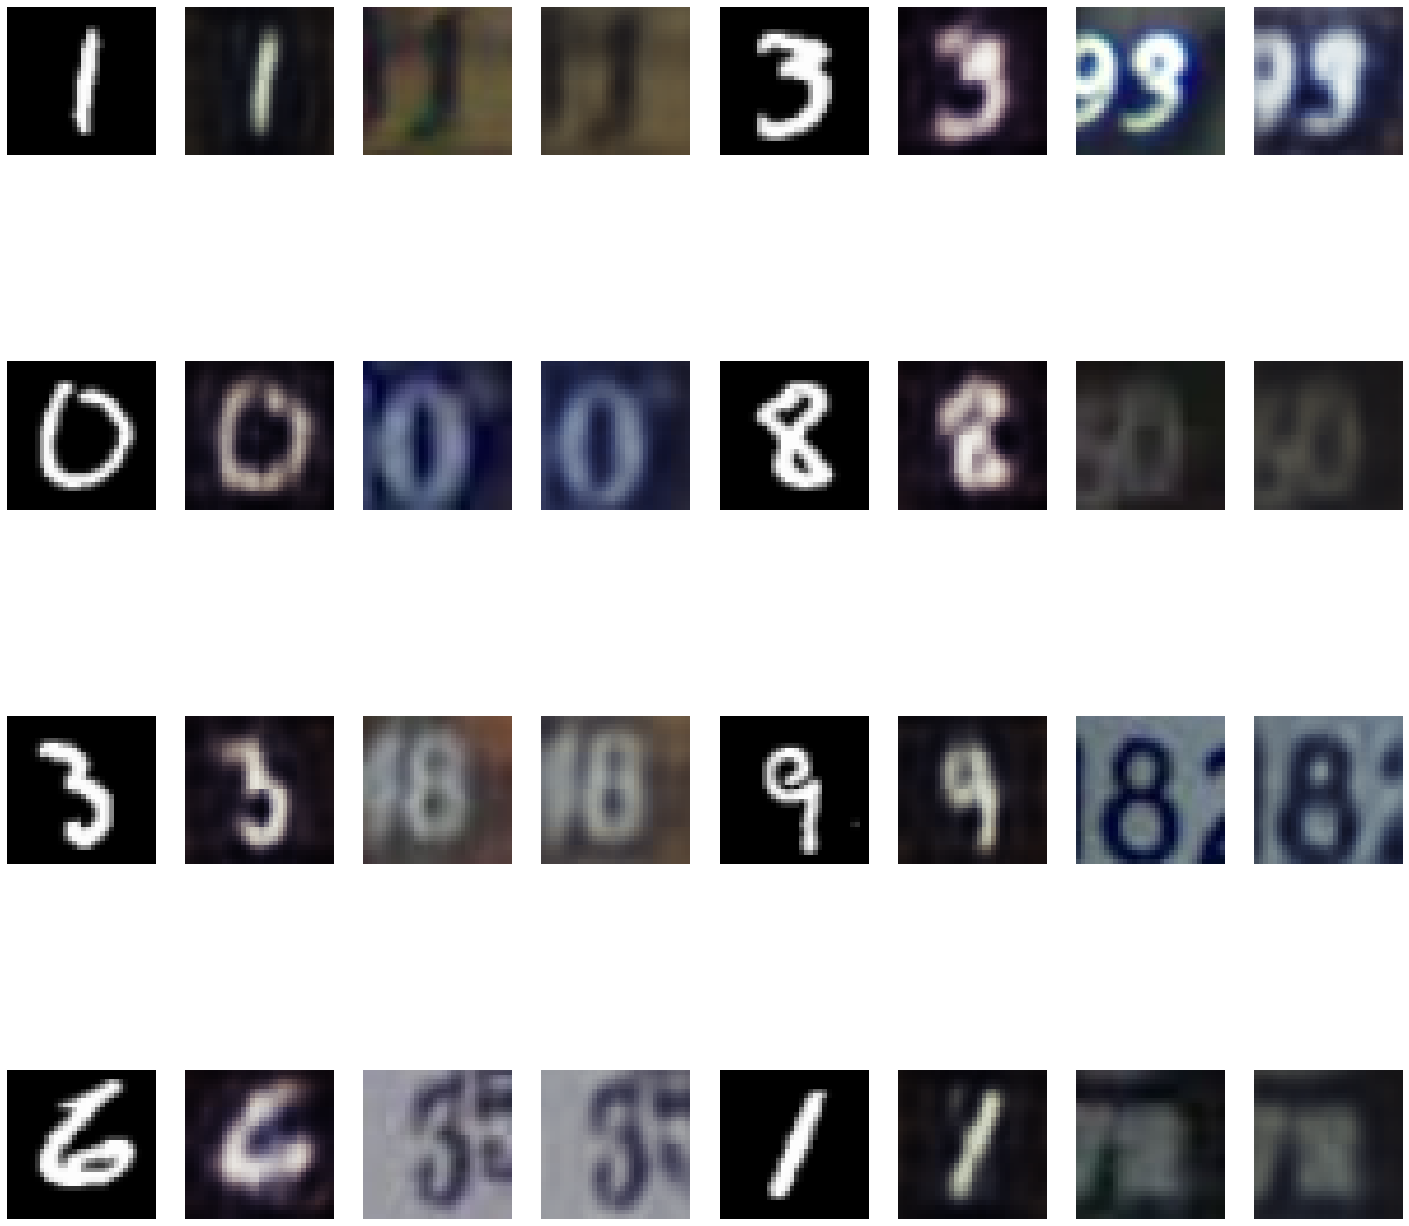

In [26]:
mnist_test_sample, _ = iter(mnist_test_loader).next()
svhn_test_sample, _ = iter(svhn_test_loader).next()
mnist_test_decoded = autoencoder(mnist_test_sample.to(device))
svhn_test_decoded = autoencoder(svhn_test_sample.to(device))

plt.figure(figsize=(25,25))
toPIL = transforms.ToPILImage()
for idx, (mnist_img, mnist_img_decoded, svhn_img, svhn_img_decoded) in enumerate(zip(mnist_test_sample, mnist_test_decoded, svhn_test_sample, svhn_test_decoded), 1):
    plt.subplot(4,8,idx*4-3)
    plt.imshow(toPIL(mnist_img), cmap="gray")
    plt.axis("off")
    plt.subplot(4,8,idx*4-2)
    plt.imshow(toPIL(mnist_img_decoded), cmap="gray")
    plt.axis("off")
    plt.subplot(4,8,idx*4-1)
    plt.imshow(toPIL(svhn_img), cmap="gray")
    plt.axis("off")
    plt.subplot(4,8,idx*4)
    plt.imshow(toPIL(svhn_img_decoded), cmap="gray")
    plt.axis("off")

## AdaIN

### Helper Functions

In [27]:
EPS = 1e-5

def get_mean_std(data):
    assert (
        len(data.shape) == 4
    ), "data must have shape of (batch_size, n_channels, height, width)"

    batch_size, n_channels = data.shape[:2]

    flattened_data = data.view(batch_size, n_channels, -1)
    mean = flattened_data.mean(axis=2).view(batch_size, n_channels, 1,1)
    variance = (flattened_data.var(axis=2) + EPS).sqrt().view(batch_size, n_channels, 1,1)
    return mean, variance

def get_content_loss(inputs, targets):
    return F.mse_loss(inputs, targets)

def get_style_loss(inputs, targets):
    inputs_mean, inputs_std = get_mean_std(inputs)
    targets_mean, targets_std = get_mean_std(targets)
    return F.mse_loss(inputs_mean, targets_mean) + F.mse_loss(inputs_std, targets_std)

def adaptive_instance_normalization(content, style):
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)

    return (content - content_mean)/content_std * style_std + style_mean

### Style Transfer Network

In [28]:
class StyleTransfer(nn.Module):
    def __init__(self, encoder=None, decoder=None):
        super(StyleTransfer, self).__init__()
        if encoder is None:
            self.encoder = Encoder()
        else:
            self.encoder = encoder
        if decoder is None:
            self.decoder = Decoder()
        else:
            self.decoder = decoder

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1.0, "alpha must be from 0 to 1"
        encoded_content = self.encoder(content)
        encoded_style = self.encoder(style)
        if self.training:
            latent_styled_content = adaptive_instance_normalization(encoded_content, encoded_style)
        else:
            latent_styled_content = alpha*adaptive_instance_normalization(encoded_content, encoded_style) + (1-alpha)*encoded_content
        styled_content = self.decoder(encoded_content)
        encoded_styled_content = self.encoder(styled_content)

        return latent_styled_content, encoded_styled_content, encoded_style

### Style Transfer Network Training

In [29]:
def train_one_epoch(
    model,
    device,
    content_loader,
    style_loader,
    gamma,
    optimizer,
    scheduler,
    curr_epoch,
    tot_epochs,
):
    running_loss = 0.0
    num_iters = 0
    model.train()
    with tqdm(zip(content_loader, style_loader), total=len(content_loader)) as loop:
        for contents, styles in loop:
            optimizer.zero_grad()

            content = contents[0].to(device)
            style = styles[0].to(device)

            latent_styled_content, encoded_styled_content, encoded_style = model(
                content, style
            )
            content_loss = get_content_loss(
                latent_styled_content, encoded_styled_content
            )
            style_loss = get_style_loss(encoded_style, encoded_styled_content)
            total_loss = content_loss + gamma * style_loss

            total_loss.backward()

            optimizer.step()

            num_iters += 1

            running_loss += total_loss.item()
            avg_loss = running_loss / num_iters

            loop.set_description(f"Epoch [{curr_epoch+1}/{tot_epochs}]")
            loop.set_postfix(
                loss=avg_loss,
            )

        scheduler.step()

    return running_loss


def fit(
    model,
    device,
    content_loader,
    style_loader,
    gamma,
    optimizer,
    scheduler,
    epochs,
    writer,
):

    best_loss = float("inf")
    Path("models").mkdir(parents=True, exist_ok=True)
    for epoch in range(epochs):
        running_loss = train_one_epoch(
            model,
            device,
            content_loader,
            style_loader,
            gamma,
            optimizer,
            scheduler,
            epoch,
            epochs,
        )
        avg_loss = running_loss / len(content_loader.dataset)

        writer.add_scalars("Training Loss", {"loss": avg_loss}, epoch + 1)
        writer.flush()

        if avg_loss < best_loss:
            best_loss = avg_loss
            model_path = Path("models/model_{}_{}".format(TIME_STAMP, epoch + 1))
            torch.save(model.state_dict(), model_path)

### Building Model

In [30]:
style_transfer = StyleTransfer(autoencoder.encoder, autoencoder.decoder).to(device)
print(summary(style_transfer.encoder, input_size=(8, 3, 32, 32)))
print(summary(style_transfer.decoder, input_size=(8, 128, 2, 2)))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  --                        --
├─Sequential: 1-1                        [8, 128, 2, 2]            --
│    └─Conv2d: 2-1                       [8, 16, 32, 32]           448
│    └─ReLU: 2-2                         [8, 16, 32, 32]           --
│    └─MaxPool2d: 2-3                    [8, 16, 16, 16]           --
│    └─Conv2d: 2-4                       [8, 32, 16, 16]           4,640
│    └─ReLU: 2-5                         [8, 32, 16, 16]           --
│    └─MaxPool2d: 2-6                    [8, 32, 8, 8]             --
│    └─Conv2d: 2-7                       [8, 64, 8, 8]             18,496
│    └─ReLU: 2-8                         [8, 64, 8, 8]             --
│    └─MaxPool2d: 2-9                    [8, 64, 4, 4]             --
│    └─Conv2d: 2-10                      [8, 128, 4, 4]            73,856
│    └─ReLU: 2-11                        [8, 128, 4, 4]            --
│  

### Hyperparameters

In [32]:
TIME_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/{TIME_STAMP}")

gamma = 10.0

init_lr = 0.1
optimizer = Adam(style_transfer.parameters(), lr=init_lr)
scheduler = ExponentialLR(optimizer, gamma=0.97)

epochs = 15

In [78]:
%tensorboard --logdir runs/{TIME_STAMP}

<IPython.core.display.Javascript object>

In [80]:
fit(
    style_transfer,
    device,
    mnist_train_loader,
    svhn_train_loader,
    gamma,
    optimizer,
    scheduler,
    epochs,
    writer,
)

  0%|          | 0/7500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Misc

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
!cp drive/MyDrive/CoE197Z/AdaIN/mix/models/ae_weights .

In [58]:
!cp -r {runs,models} drive/MyDrive/CoE197Z/AdaIN/svhn

In [59]:
drive.flush_and_unmount()

In [ ]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [ ]:
model = StyleTransfer()
# a.train()
# print(a.encoder.training, a.decoder.training)
ae = list(model.parameters())
a = list(model.encoder.parameters())
e = list(model.decoder.parameters())
print(len(ae))
print(len(a))
print(len(e))

20
10
10
